# Підготовка та Аналіз даних #

## Лабораторна робота №5 ##

## Візуалізація даних ##

### Мета роботи: 
отримати поглиблені навички з візуалізації даних; ознайомитись з matplotlib.widgets,
scipy.signal.filters, а також з Plotly, Bokeh, Altair; отримати навички зі створення інтерактивних
застосунків для швидкого підбору параметрів і аналізу отриманих результатів

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, CheckButtons
from scipy.signal import iirfilter, sosfiltfilt
print("Ok")

Ok


Завдання 1,2

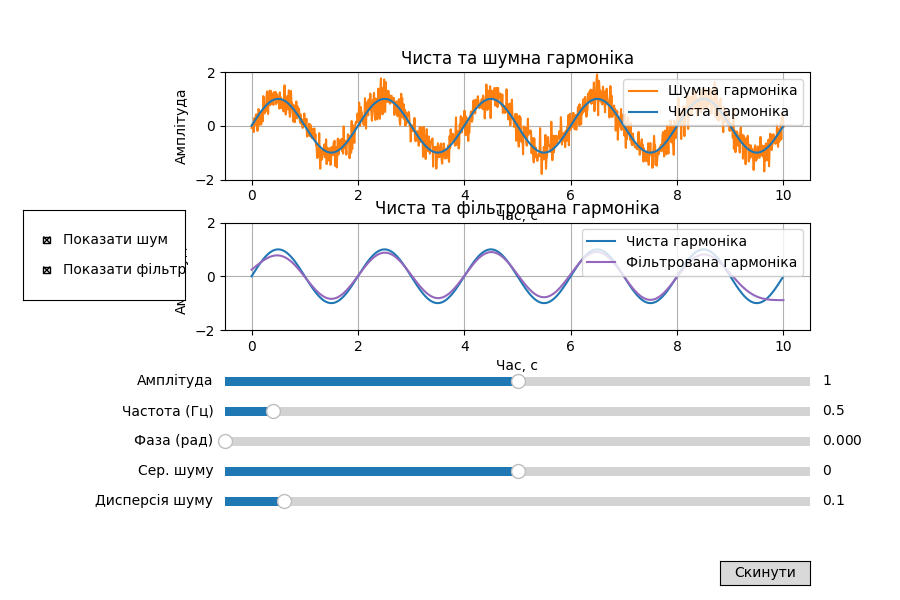

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, CheckButtons
from scipy.signal import iirfilter, sosfiltfilt
init_amplitude = 1.0
init_frequency = 0.5
init_phase = 0.0
init_noise_mean = 0.0
init_noise_cov = 0.1
show_noise = True
show_filtered = True

margin = 0.25   # +25 % до частоти зрізу щоб норм виглядало, і синусоїда не глушилася
filter_order = 4 # порядок Баттерворта

t = np.linspace(0, 10, 1000) #час від 0 до 10 на 1000 точок
fs = (len(t) - 1) / (t[-1] - t[0]) #99.9 Гц(відображення максимальної частоти без спотворень)


def harmonic(A, f, phi, t):
    return A * np.sin(2 * np.pi * f * t + phi)


def harmonic_with_noise(A, f, phi, t, noise):
    return harmonic(A, f, phi, t) + noise


def design_lowpass(cutoff_hz, fs, order=filter_order):
    """фільтр баттерворта 4 порядку, для мінімізації сповторення сигналу.
    По-факту розбиття"""
    wn = cutoff_hz / (0.5 * fs)
    sos = iirfilter(order, wn, btype='low', ftype='butter', output='sos') #рекурсивний фільтр для отримання набору коефіцієнтів для фільтру
    return sos


def apply_filter(sig, sos):
    """фільтруємо отримані коефіцінієнти другого порядку. Завдяки тому, що фільтр проходить вперед-назад то й немає зсуву"""
    return sosfiltfilt(sos, sig)


noise = np.random.normal(init_noise_mean, np.sqrt(init_noise_cov), len(t)) #початковий шум
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6))
plt.subplots_adjust(left=0.25, bottom=0.45, hspace=0.4)

#верхній графік чиста + шум
pure0 = harmonic(init_amplitude, init_frequency, init_phase, t)
noisy0 = harmonic_with_noise(init_amplitude, init_frequency, init_phase, t, noise)

noise_line, = ax1.plot(t, noisy0, color='tab:orange', label='Шумна гармоніка')
harmonic_line1, = ax1.plot(t, pure0,  color='tab:blue',   label='Чиста гармоніка')
ax1.set(title='Чиста та шумна гармоніка', xlabel='Час, с', ylabel='Амплітуда', ylim=(-2, 2))
ax1.grid(True); ax1.legend(loc='upper right')

#нижній графік чиста + фільтрована
sos0 = design_lowpass(init_frequency * (1 + margin), fs)
filtered0 = apply_filter(noisy0, sos0)

harmonic_line2, = ax2.plot(t, pure0,     color='tab:blue',   label='Чиста гармоніка')
filtered_line,  = ax2.plot(t, filtered0, color='tab:purple', label='Фільтрована гармоніка')
ax2.set(title='Чиста та фільтрована гармоніка', xlabel='Час, с', ylabel='Амплітуда', ylim=(-2, 2))
ax2.grid(True); ax2.legend(loc='upper right')

#слайдери
axA = plt.axes([0.25, 0.35, 0.65, 0.03]); sA = Slider(axA, 'Амплітуда', 0.0, 2.0, valinit=init_amplitude)
axF = plt.axes([0.25, 0.30, 0.65, 0.03]); sF = Slider(axF, 'Частота (Гц)', 0.1, 5.0, valinit=init_frequency)
axP = plt.axes([0.25, 0.25, 0.65, 0.03]); sP = Slider(axP, 'Фаза (рад)', 0.0, 2*np.pi, valinit=init_phase)
axNM= plt.axes([0.25, 0.20, 0.65, 0.03]); sNM= Slider(axNM,'Сер. шуму', -1.0, 1.0, valinit=init_noise_mean)
axNC= plt.axes([0.25, 0.15, 0.65, 0.03]); sNC= Slider(axNC,'Дисперсія шуму', 0.0, 1.0, valinit=init_noise_cov)

#чекбокси та кнопка
rax = plt.axes([0.025, 0.5, 0.18, 0.15])
check = CheckButtons(rax, ['Показати шум', 'Показати фільтр'], [show_noise, show_filtered])

reset_ax = plt.axes([0.8, 0.025, 0.1, 0.04])
btn_reset = Button(reset_ax, 'Скинути', hovercolor='0.975')

def redraw():
    pure = harmonic(sA.val, sF.val, sP.val, t)
    harmonic_line1.set_ydata(pure)
    harmonic_line2.set_ydata(pure)

    noisy = harmonic_with_noise(sA.val, sF.val, sP.val, t, noise)
    if check.get_status()[0]:   #показати шум
        noise_line.set_ydata(noisy); noise_line.set_visible(True)
    else:
        noise_line.set_visible(False)

    if check.get_status()[1]:   #показати фільтр
        sos = design_lowpass(sF.val * (1 + margin), fs)
        filtered_line.set_ydata(apply_filter(noisy, sos))
        filtered_line.set_visible(True)
    else:
        filtered_line.set_visible(False)

    fig.canvas.draw_idle()


def on_slider_change(_): #колбек функція для уникнення помилки, бо redraw не завжди щось повертає і буде помилка. В цілому можна redraw(_), але для більшої читаємості так
    redraw()


def on_noise_change(_): #зміна шуму на слайдерах
    global noise
    noise = np.random.normal(sNM.val, np.sqrt(sNC.val), len(t)) #середнє + дисперсія
    redraw()


def on_reset(_):
    sA.reset(); sF.reset(); sP.reset(); sNM.reset(); sNC.reset() # скидаємо всі слайдери
    if not check.get_status()[0]: check.set_active(0) # вмикаємо показати шум
    if not check.get_status()[1]: check.set_active(1) # вмикаємо показати фільтр

#підключення обробників
sA.on_changed(on_slider_change) #передає аргумент в on_slider_change
sF.on_changed(on_slider_change)
sP.on_changed(on_slider_change)
sNM.on_changed(on_noise_change)
sNC.on_changed(on_noise_change)
check.on_clicked(on_slider_change)
btn_reset.on_clicked(on_reset)

plt.show()


Завдання 3 (altair)

In [9]:
import numpy as np
import altair as alt
import pandas as pd
import streamlit as st

init_amplitude = 1.0
init_frequency = 0.5
init_phase = 0.0
init_noise_mean = 0.0
init_noise_covariance = 0.1


t = np.linspace(0, 10, 1000) #час від 0 до 10 на 1000 точок
fs = (len(t) - 1) / (t[-1] - t[0]) #частота дискретизації(відображення максимальної частоти без спотворень)


def harmonic(A, f, phi, t):
    return A * np.sin(2 * np.pi * f * t + phi)


def harmonic_with_noise(A, f, phi, t, noise):
    return harmonic(A, f, phi, t) + noise


def moving_average(x, window_size=5): #вираховуємо рухоме середнє по точкам сигналів
    result = np.zeros_like(x) # масив з нулями розміру x
    for i in range(len(x)):
        start = max(0, i - window_size + 1) #початок вікна
        result[i] = np.mean(x[start:i+1]) #середнє значення на відрізку
    return result


def generate_noise(mean, cov, size):
    return np.random.normal(mean, np.sqrt(cov), size)


#streamlit
st.title("Інтерактивна гармоніка + власний фільтр (Altair + Streamlit)")
st.sidebar.header("Налаштування сигналу")
amplitude = st.sidebar.slider('Амплітуда', 0.0, 2.0, init_amplitude, 0.05)
frequency = st.sidebar.slider('Частота (Гц)', 0.1, 5.0, init_frequency, 0.1)
phase = st.sidebar.slider('Фаза (рад)', 0.0, 2*np.pi, init_phase, 0.1)
noise_mean = st.sidebar.slider('Середнє шуму', -1.0, 1.0, init_noise_mean, 0.05)
noise_cov = st.sidebar.slider('Дисперсія шуму', 0.0, 1.0, init_noise_covariance, 0.01)

filter_type = st.sidebar.selectbox('Тип фільтра', 'Рухоме середнє')

#генерація сигналів
noise = generate_noise(noise_mean, noise_cov, len(t))
pure = harmonic(amplitude, frequency, phase, t)
noisy = harmonic_with_noise(amplitude, frequency, phase, t, noise)

if filter_type == 'Рухоме середнє':
    filtered = moving_average(noisy, window_size=15)
else:
    filtered = noisy

#перетворення в DataFrame
data = pd.DataFrame({
    'Час': t,
    'Чиста гармоніка': pure,
    'Шумна гармоніка': noisy,
    'Фільтрована гармоніка': filtered
})

#графіки
st.subheader("чиста + шумна")
fig1 =alt.Chart(data).mark_line(color='orange').encode(
    x='Час',
    y='Шумна гармоніка'
) + alt.Chart(data).mark_line(color='blue').encode(
    x='Час',
    y='Чиста гармоніка'
)

fig1 = fig1.properties(width=700, height=300)
st.altair_chart(fig1, use_container_width=True)

st.subheader("чиста + фільтрована")
fig2 = alt.Chart(data).mark_line().encode(
    x='Час',
    y='Чиста гармоніка',
    color=alt.value('blue')
) + alt.Chart(data).mark_line().encode(
    x='Час',
    y='Фільтрована гармоніка',
    color=alt.value('purple')
)
fig2 = fig2.properties(width=700, height=300)
st.altair_chart(fig2, use_container_width=True)

2025-04-26 08:38:21.763 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 08:38:21.764 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 08:38:21.764 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 08:38:21.765 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 08:38:21.766 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 08:38:21.766 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 08:38:21.767 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-26 08:38:21.768 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()